In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.special import softmax
from scipy.spatial.distance import euclidean

# MS: TODO comment out for now
#import biomart

import umap
import pickle
import scipy.spatial as sp
import seaborn as sns
import itertools

from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris

from scipy.spatial.distance import pdist,squareform
from scipy.cluster import hierarchy

import glob

# Goal = Attempt to recreate Fig. 2 of biorxiv manuscript

Utility functions

In [ ]:
""" code from Karin2024
def run(self, x0, w, beta, dt=0.1, tmax=10):
    x=x0.copy()
    hist = []
    for t in np.arange(0,tmax,dt):
        hist.append(x.copy())
        x+=dt*(np.matmul(self.Q.T,softmax(w+beta*np.matmul(self.XI,x)))-x)
        
    hist = np.array(hist)
    return x,hist
"""

def run_traj(f_of_xtp, x0, params, t0=0.0, tmax=10.0, dt_max=0.1):
    
    # if euler
    times_traj = np.arange(t0, tmax + dt_max, dt_max)    # suze T
    x_traj = np.zeros((len(times_traj), x0.shape[0]))    # size T x N
    
    x_traj[0, :] = x0
    for idx, tval in enumerate(times_traj[:-1]): 
        current_vel = f_of_xtp(x_traj[idx, :], tval, params) 
        x_traj[idx+1, :] = x_traj[idx, :] + dt_max * current_vel
        
    # if scipy integrator
    # TODO implement radau call
    
    return x_traj, times_traj

## Silly example testing the generalic trajectory function: 
## - launch particle, only force is gravity $d v_y / dt = -g$

In [74]:
# Note: keep signature of function fixed for now as x, t, p - state [dim N], times [scalar], params [dim p]
# TODO jit all func, or torch for eventual Autodiff

def dxdt_particle(x, t, params):
    """
    # Throw a ball in R^2
    # Three params: vx0, vy0, gravity
    """
    vx0, vy0, g = params
    dxdt = vx0
    dydt = vy0 - g*t
    return np.array([dxdt, dydt])

# sample call
dxdt_particle([10,10], 0, [1, 1, 9.8])

array([1., 1.])

In [75]:
x0 = np.array([10,100])
params = [1, 10, 9.8]
x_traj, times_traj = run_traj(dxdt_particle, x0, params, t0=0.0, tmax=2, dt_max=0.1)

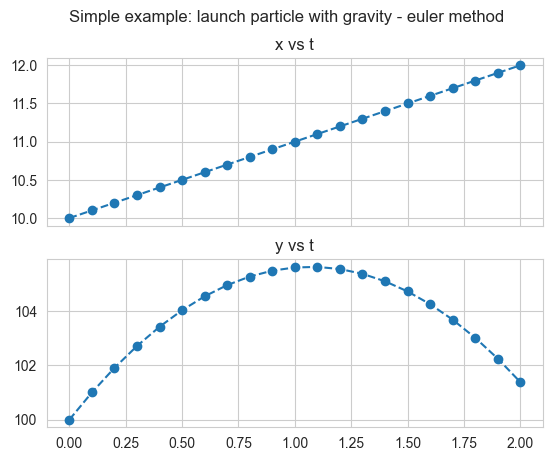

In [76]:
fig, axarr = plt.subplots(2, 1, sharex=True)
pltstyle = dict(linestyle='--', marker='o')
axarr[0].plot(times_traj, x_traj[:,0], **pltstyle); axarr[0].set_title('x vs t') 
axarr[1].plot(times_traj, x_traj[:,1], **pltstyle); axarr[1].set_title('y vs t')
plt.suptitle('Simple example: launch particle with gravity - euler method')
plt.show(); plt.close('all')

# Classic (quadratic) hopfield network with continuous variables $x \in \mathbb{R}^N$
## $\frac{dx}{dt} = -x + \textrm{tanh}(\beta [Jx + b])$

where 

- $\beta=1/T$ is inverse temperature -- at zero temperature limit its digital (sign function)
- $J=\xi \xi^T$ is defined by the $N \times K$ matrix of cell types, with cell type $\mu=1, ..., K$ indexing the cell types represented by columns of $\xi$ 
- $b \in \mathbb{R}^N$ is an $N$ dimensional applied field on specific genes; we will reserve $w \in \mathbb{R}^K$ to denote an analogous forcing applied in the direction of the $K$ encoded cell types

#### Note on alternative RBM-like two-layer form (TODO q: is it equivalent?):
- $\tau_x\: \frac{dx}{dt} = -x + \xi \,f(m) + b$
- $\tau_m\: \frac{dm}{dt} = -m + \xi^T \,g(x) + w$

where $f:\mathbb{R}^K \rightarrow :\mathbb{R}^N$, $g:\mathbb{R}^N \rightarrow :\mathbb{R}^K$ are potentially nonlinear functions of a given neuron (e.g. $f_{\mu} \equiv \textrm{tanh}(m_{\mu})$  or the entire layer (e.g. in the case of $\textrm{softmax}$). Similar notation is used in Krotov and Hopfield (2021, ICLR). 

##### Comment on relative timescales for the two-layer dynamics
If one timescale ($\tau_x, \tau_m$) is much faster (i.e. small $\tau$), then the associated dynamics can be eliminated (treated as being at "quasi-steady-state"). In that case, the coupled dynamics can be viewed as a "singular expansion" of the uncoupled form. 

E.g., if $\tau_m \ll \tau_x$, then $m(t) \approx \xi^T g(x) + w$ at all times (since any deviation will rapidly be corrected, relatively speaking).

As a concrete example, the following choice of $f$, $g$ maps to a classic hebbian Hopfield network (TODO check this vs. form above; if $b$ is outside the $\textrm{tanh}$ then state can leave the $\pm 1$ hypercube): 
- $\tau_x\: \frac{dx}{dt} = -x + \xi \:\textrm{tanh}(\beta m) + b$
- $\tau_m\: \frac{dm}{dt} = -m + \xi^T x + w$
 
Assuming  $\tau_m \ll \tau_x$ and making the QSS substituton gives the condensed dynamics $\tau_x\: dx/dt = -x + \xi \:\textrm{tanh} \left[ \beta (\xi^T x + w) \right] + b$.

#### Additional notes from recent [Krotov and Hopfield, 2021, ICLR]
TODO...

#### Additional remarks
The main dynamics stated at the top are not unique. The nonlinearity can be applied before or after the linearity. Here is a general recipe for a recurrent dynamics in $\mathbb^N$ combining an affine transform and a static elementwise nonlinearity $\sigma(z)$:
- Option 1:  $dx/dt = -x + \sigma(Ax + b)$  
- Option 2:  $dy/dt = -y + A\sigma(y) + b$  

I tend to prefer Option 1, but they seem to be equivalent through the linear change of variables $y=Ax+b$ (can check by differentiation).  

I also tend to use the nonlinearity $\sigma(z) = \textrm{tanh}(\beta z)$. This choice is inspired by the mean-spin flip update rule of the binary Ising model with (stochastic) Glauber dynamics. It has a nice interpretation that any fixed point lies in or on the $\pm 1$ hypercube ($\equiv \Omega_N$); more generally, note that $\Omega_N$ is positively invariant for this choice of $\sigma(z)$. To "think outside the box", one could consider alternative nonlinearities like $\sigma(z)=\textrm{ReLU}(z)$. 
  

In [78]:
# Note: keep signature of function fixed for now as x, t, p - state [dim N], times [scalar], params [dim p]
# TODO jit all func, or torch for eventual Autodiff

def dxdt_HN_quadratic_hebb(x, t, params):
    """
    # Throw a ball in R^2
    # Three params: vx0, vy0, gravity
    """
    vx0, vy0, g = params
    dxdt = vx0
    dydt = vy0 - g*t
    return np.array([dxdt, dydt])

# sample call
dxdt_particle([10,10], 0, [1, 1, 9.8])

array([1., 1.])

# Now let's implement the modern Hopfield network vector field 
## $dx/dt = ...$

In [79]:
# Note: keep signature of function fixed for now as x, t, p - state [dim N], times [scalar], params [dim p]
# TODO jit all func, or torch for eventual Autodiff

def dxdt_particle(x, t, params):
    """
    # Throw a ball in R^2
    # Three params: vx0, vy0, gravity
    """
    vx0, vy0, g = params
    dxdt = vx0
    dydt = vy0 - g*t
    return np.array([dxdt, dydt])

# sample call
dxdt_particle([10,10], 0, [1, 1, 9.8])

array([1., 1.])

In [75]:
x0 = np.array([10,100])
params = [1, 10, 9.8]
x_traj, times_traj = run_traj(dxdt_particle, x0, params, t0=0.0, tmax=2, dt_max=0.1)

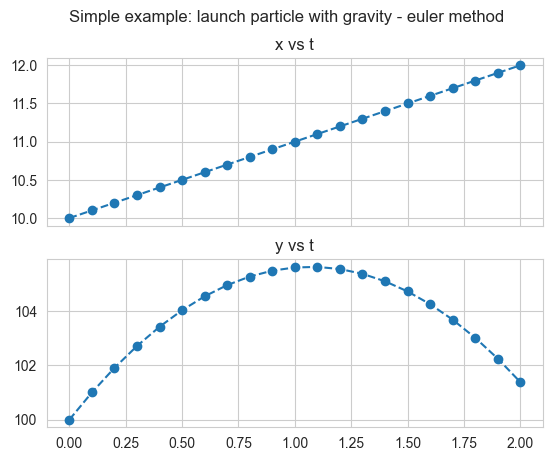

In [76]:
fig, axarr = plt.subplots(2, 1, sharex=True)
pltstyle = dict(linestyle='--', marker='o')
axarr[0].plot(times_traj, x_traj[:,0], **pltstyle); axarr[0].set_title('x vs t') 
axarr[1].plot(times_traj, x_traj[:,1], **pltstyle); axarr[1].set_title('y vs t')
plt.suptitle('Simple example: launch particle with gravity - euler method')
plt.show(); plt.close('all')